In [1]:
import utils
import metrics
import CNNLSTMModel
import ConvLSTM2DModel

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

LUCKY_NUMBER = 2
TARGET_SIZE = (128, 128) # For no compression choose -1
TARGET_SLICES = 100

PHOTOS_PATH = "/media/kaczmarski/DataStorage/images/"
MASK_PATH = "/media/kaczmarski/DataStorage/masks/"

2025-01-03 11:28:19.147086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 11:28:19.153879: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 11:28:19.217099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 11:28:19.281700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735900099.334282  102417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735900099.35

In [ ]:
print("GPUs Available: ",tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Prepare data

In [2]:
np.random.seed(LUCKY_NUMBER)
batch_size = 1
epochs = 40

scan_names = [file[:8] for file in os.listdir(PHOTOS_PATH) if file.endswith(".nii.gz")]
train, val, test = utils.split_train_val_test(scan_names, 0.7, 0.15, 0.15)
print(f"Training data size: {len(train)}, Validation data size: {len(val)}, Test data size: {len(test)}")

print(train)
train_gen = utils.cbct_data_generator(PHOTOS_PATH, MASK_PATH, train, batch_size)
val_gen = utils.cbct_data_generator(PHOTOS_PATH, MASK_PATH, val, batch_size)
test_gen = utils.cbct_data_generator(PHOTOS_PATH,MASK_PATH,test, batch_size)


#model = CNNLSTMModel.create_cnn_lstm_model(image_shape=TARGET_SIZE, num_slices=50)
#model = ConvLSTM2DModel.create_cnn_convlstm2d_model(image_shape=TARGET_SIZE, num_slices=TARGET_SLICES)
model = tf.keras.models.load_model("models/5-convlstm.keras",
                                   custom_objects = {
                                       "dice_binary_crossentropy_loss": metrics.dice_binary_crossentropy_loss,
                                       "dice_coefficient": metrics.dice_coefficient,
                                       "jaccard_index": metrics.jaccard_index
                                   })
model.summary()

Training data size: 98, Validation data size: 21, Test data size: 21
['ZEBY_183', 'ZEBY_218', 'ZEBY_107', 'ZEBY_202', 'ZEBY_209', 'ZEBY_130', 'ZEBY_160', 'ZEBY_122', 'ZEBY_117', 'ZEBY_194', 'ZEBY_128', 'ZEBY_136', 'ZEBY_182', 'ZEBY_178', 'ZEBY_232', 'ZEBY_224', 'ZEBY_200', 'ZEBY_201', 'ZEBY_185', 'ZEBY_124', 'ZEBY_179', 'ZEBY_227', 'ZEBY_119', 'ZEBY_162', 'ZEBY_175', 'ZEBY_102', 'ZEBY_157', 'ZEBY_120', 'ZEBY_206', 'ZEBY_110', 'ZEBY_161', 'ZEBY_135', 'ZEBY_141', 'ZEBY_111', 'ZEBY_199', 'ZEBY_187', 'ZEBY_127', 'ZEBY_133', 'ZEBY_237', 'ZEBY_163', 'ZEBY_158', 'ZEBY_174', 'ZEBY_238', 'ZEBY_118', 'ZEBY_190', 'ZEBY_240', 'ZEBY_198', 'ZEBY_109', 'ZEBY_214', 'ZEBY_223', 'ZEBY_150', 'ZEBY_180', 'ZEBY_230', 'ZEBY_228', 'ZEBY_220', 'ZEBY_151', 'ZEBY_177', 'ZEBY_153', 'ZEBY_181', 'ZEBY_167', 'ZEBY_229', 'ZEBY_184', 'ZEBY_233', 'ZEBY_171', 'ZEBY_147', 'ZEBY_169', 'ZEBY_189', 'ZEBY_170', 'ZEBY_222', 'ZEBY_159', 'ZEBY_134', 'ZEBY_207', 'ZEBY_139', 'ZEBY_204', 'ZEBY_152', 'ZEBY_208', 'ZEBY_143', 'ZEBY_

W0000 00:00:1735564696.317239  570788 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 100, 128, 128,  │         9,856 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 100, 64, 64,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 64, 64,    │             0 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 100, 64, 64,    │        55,424 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 100, 32, 32,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 100, 32, 32,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 100, 32, 32,    │       221,440 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 100, 16, 16,    │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 100, 16, 16,    │             0 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 100, 32, 32,    │        36,928 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 100, 64, 64,    │        18,464 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 100, 128, 128,  │         4,624 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 100, 128, 128,  │            17 │
│ (TimeDistributed)               │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,040,261 (3.97 MB)

 Trainable params: 346,753 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 693,508 (2.65 MB)

get weights of trained model to change loss function

In [ ]:
weights = model.get_weights()

model = ConvLSTM2DModel.create_cnn_convlstm2d_model(image_shape=TARGET_SIZE, num_slices=TARGET_SLICES)

model.set_weights(weights)

model.summary()

Train model

In [ ]:
model.layers[9].input.shape

In [ ]:
model.fit(
    train_gen, 
    batch_size=batch_size,
    steps_per_epoch=len(train),
    validation_data=val_gen,
    validation_steps=len(val),
    epochs=epochs)

In [ ]:
utils.save_model(model)

Make prediction

In [ ]:
test_scan_orig = utils.load_nifti_cbct_scan(PHOTOS_PATH+test[20]+"_0000.nii.gz")
test_scan = test_scan_orig[..., np.newaxis]
test_scan = np.expand_dims(test_scan, axis=0)

predictions = model.predict(test_scan)

predicted_mask = predictions[0]

binary_mask = (predicted_mask > 0.5).astype(np.float32)

print(predicted_mask[25,:,:,0] == predicted_mask[30,:,:,0])

plt.imshow(predicted_mask[25, :, :, 0], cmap="gray")

Plot results

In [ ]:
slice_index = 70
original_mask = utils.load_nifti_mask(MASK_PATH+test[20]+".nii.gz")

plt.figure(figsize=(7, 7))
plt.subplot(2, 2, 1)
plt.title("a)")
plt.imshow(test_scan[0, slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("b)")
plt.imshow(original_mask[slice_index,:,:], cmap="gray")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("c)")
plt.imshow(binary_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')


plt.subplot(2, 2, 4)
plt.title("d)")
plt.imshow(np.zeros((64, 64)), cmap="gray")

teeth = np.ma.masked_where(original_mask[slice_index,:,:] == 0, original_mask[slice_index,:,:])
teeth = teeth[20:84,33:97]
plt.imshow(teeth, cmap="Set1")

pred_teeth = np.ma.masked_where(binary_mask[slice_index,:,:] == 0, binary_mask[slice_index,:,:])
pred_teeth = pred_teeth[20:84,33:97]
plt.imshow(pred_teeth, cmap="Dark2")

plt.axis('off')
plt.show()

plt.savefig("plots/predict_example.png")

In [ ]:
utils.plot_image_with_mask_grid(test_scan_orig, original_mask, start_idx=0, end_idx=100)

In [ ]:
utils.plot_image_with_mask_grid(test_scan_orig, binary_mask, start_idx=0, end_idx=100, cmap_of_teeth="Dark2")

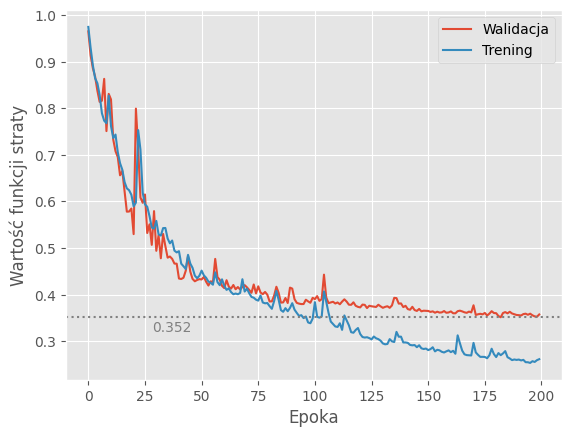

In [2]:
import matplotlib.pyplot as plt
import json

with open("models/2-convlstm2d-dice60-history.json", "r") as file:
    history_2 = json.load(file)

with open("models/1-convlstm2d-dice50-128-history.json", "r") as file:
    history_1 = json.load(file)

with open("models/3-convlstm2d.json", "r") as file:
    history_3 = json.load(file)

with open("models/4-convlstm-history.json", "r") as file:
    history_4 = json.load(file)

with open("models/5-convlstm-history.json", "r") as file:
    history_5 = json.load(file)

#val_loss = np.array([np.array(history_1["val_loss"]),np.array(history_2["val_loss"])+0.05,np.array(history_50["val_loss"])])

val_loss = []

for value in history_1["val_loss"]:
    val_loss.append(value)

for value in np.array(history_2["val_loss"])+0.05:
    val_loss.append(value)

for value in history_3["val_loss"]:
    val_loss.append(value)

for value in history_4["val_loss"]:
    val_loss.append(value)

for value in history_5["val_loss"]:
    val_loss.append(value)

loss = []

for value in history_1["loss"]:
    loss.append(value)

for value in np.array(history_2["loss"])+0.05:
    loss.append(value)

for value in history_3["loss"]:
    loss.append(value)

for value in history_4["loss"]:
    loss.append(value)

for value in history_5["loss"]:
    loss.append(value)

plt.figure()
plt.style.use("ggplot")
plt.plot(val_loss)
plt.plot(loss)
plt.axhline(min(val_loss),color='gray',linestyle=':')
plt.text(28, 0.32, "{:.3f}".format(min(val_loss)),color='gray')
plt.xlabel("Epoka")
plt.ylabel("Wartość funkcji straty")
plt.legend(["Walidacja","Trening"])
plt.savefig("plots/loss_plot.png")

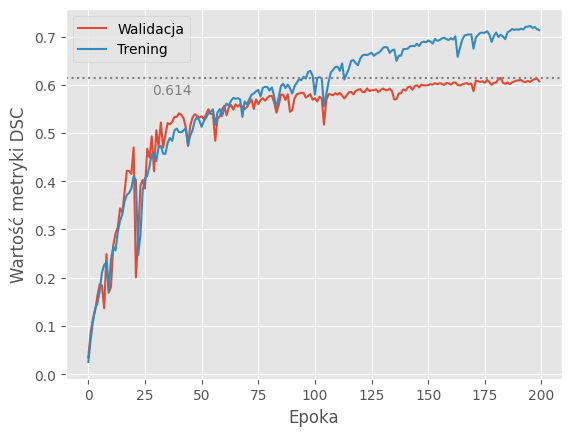

In [3]:

val_dice = []

for value in history_1["val_dice_coefficient"]:
    val_dice.append(value)

for value in history_2["val_dice_coefficient"]:
    val_dice.append(value)

for value in history_3["val_dice_coefficient"]:
    val_dice.append(value)

for value in history_4["val_dice_coefficient"]:
    val_dice.append(value)

for value in history_5["val_dice_coefficient"]:
    val_dice.append(value)

dice = []

for value in history_1["dice_coefficient"]:
    dice.append(value)

for value in history_2["dice_coefficient"]:
    dice.append(value)

for value in history_3["dice_coefficient"]:
    dice.append(value)

for value in history_4["dice_coefficient"]:
    dice.append(value)

for value in history_5["dice_coefficient"]:
    dice.append(value)

plt.figure()
plt.style.use('ggplot')
plt.plot(val_dice)
plt.plot(dice)
plt.axhline(max(val_dice),color='gray',linestyle=':')
plt.text(28, 0.58, "{:.3f}".format(max(val_dice)),color='gray')
plt.xlabel('Epoka')
plt.ylabel("Wartość metryki DSC")
plt.legend(["Walidacja","Trening"])
plt.savefig("plots/dice_plot.png")

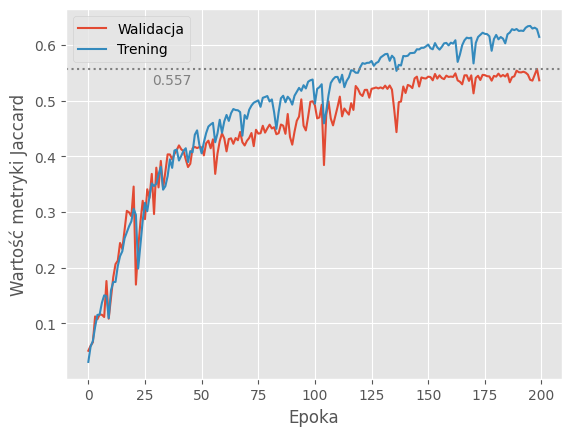

In [4]:
val_jaccard = []

for value in history_1["val_jaccard_index"]:
    val_jaccard.append(value)

for value in history_2["val_jaccard_index"]:
    val_jaccard.append(value)

for value in history_3["val_jaccard_index"]:
    val_jaccard.append(value)

for value in history_4["val_jaccard_index"]:
    val_jaccard.append(value)

for value in history_5["val_jaccard_index"]:
    val_jaccard.append(value)

jaccard = []

for value in history_1["jaccard_index"]:
    jaccard.append(value)

for value in history_2["jaccard_index"]:
    jaccard.append(value)

for value in history_3["jaccard_index"]:
    jaccard.append(value)

for value in history_4["jaccard_index"]:
    jaccard.append(value)

for value in history_5["jaccard_index"]:
    jaccard.append(value)

plt.figure()
plt.style.use('ggplot')
plt.plot(val_jaccard)
plt.plot(jaccard)
plt.axhline(max(val_jaccard),color='gray',linestyle=':')
plt.text(28, 0.53, "{:.3f}".format(max(val_jaccard)),color='gray')
plt.xlabel('Epoka')
plt.ylabel("Wartość metryki Jaccard")
plt.legend(["Walidacja","Trening"])
plt.savefig("plots/jaccard_plot.png")

In [3]:
model = tf.keras.models.load_model("models/5-convlstm.keras",
                                   custom_objects = {
                                       "dice_binary_crossentropy_loss": metrics.dice_binary_crossentropy_loss,
                                       "dice_coefficient": metrics.dice_coefficient,
                                       "jaccard_index": metrics.jaccard_index
                                   })

results = model.evaluate(test_gen,batch_size=batch_size, steps=len(test))
print(results)

Loaded ZEBY_195_0000.nii.gz.
Batch ready: scans shape (1, 100, 128, 128, 1), masks shape (1, 100, 128, 128, 1)
Loaded ZEBY_231_0000.nii.gz.
Batch ready: scans shape (1, 100, 128, 128, 1), masks shape (1, 100, 128, 128, 1)
 2/21 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - dice_coefficient: 0.2785 - jaccard_index: 0.4171 - loss: 0.6497Loaded ZEBY_197_0000.nii.gz.
Batch ready: scans shape (1, 100, 128, 128, 1), masks shape (1, 100, 128, 128, 1)
 3/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - dice_coefficient: 0.3444 - jaccard_index: 0.4289 - loss: 0.5910  Loaded ZEBY_155_0000.nii.gz.
Batch ready: scans shape (1, 100, 128, 128, 1), masks shape (1, 100, 128, 128, 1)
 4/21 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - dice_coefficient: 0.3932 - jaccard_index: 0.4430 - loss: 0.5473Loaded ZEBY_114_0000.nii.gz.
Batch ready: scans shape (1, 100, 128, 128, 1), masks shape (1, 100, 128, 128, 1)
 5/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - dice_coefficient: 0.4267 - jaccard_index: 0.4514 - loss: 0.5174Loaded ZEBY_211_0000.nii.

test zeby_211 idx 5 slice 20
train zeby_236 idx 89 slice 50
val zeby_165 idx 11 slice 50
val zeby_234 idx 9 slice 50

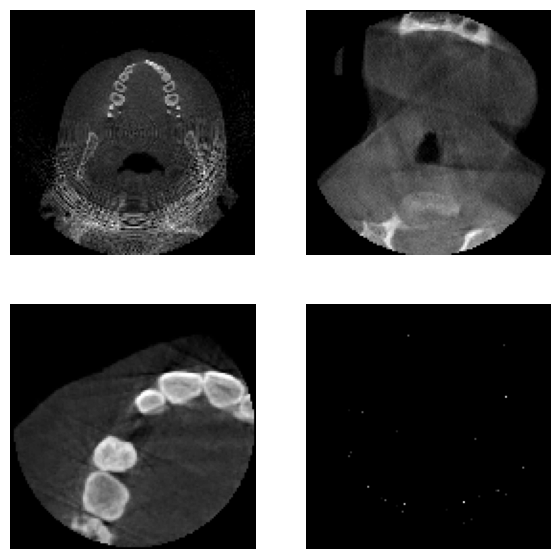

In [37]:
plt.figure(figsize=(7,7))
plt.subplot(2,2,1)
cbct = utils.load_nifti_cbct_scan(PHOTOS_PATH+"ZEBY_234_0000.nii.gz")
plt.imshow(cbct[50,:,:], cmap='gray')
plt.axis("off")

plt.subplot(2,2,2)
cbct = utils.load_nifti_cbct_scan(PHOTOS_PATH+"ZEBY_211_0000.nii.gz")
plt.imshow(cbct[20,:,:], cmap='gray')
plt.axis("off")

plt.subplot(2,2,3)
cbct = utils.load_nifti_cbct_scan(PHOTOS_PATH+"ZEBY_236_0000.nii.gz")
plt.imshow(cbct[50,:,:], cmap='gray')
plt.axis("off")

plt.subplot(2,2,4)
cbct = utils.load_nifti_cbct_scan(PHOTOS_PATH+"ZEBY_165_0000.nii.gz")
plt.imshow(cbct[50,:,:], cmap='gray')
plt.axis("off")
plt.show()
